In [1]:
%matplotlib inline

### Imports

In [2]:
import torch
from torch.utils.data import Dataset
from torchvision import datasets
from torchvision.transforms import ToTensor, Resize, ToPILImage
from torchvision.transforms.functional import to_grayscale, to_tensor
import matplotlib.pyplot as plt

import os
import pandas as pd
from torchvision.io import read_image

from torch.utils.data import DataLoader

import torch.nn as nn
import torch.nn.functional as F

import torch.optim as optim

from sklearn.metrics import classification_report, confusion_matrix

### Useful functions to retrive the data

In [3]:
# create a annotations_file.csv (img -> img, label)

def getLabelList(path):
    only_dirs = [ name for name in os.listdir(path) if 
                 os.path.isdir(os.path.join(path, name)) ]

    ret = {}
    
    for d in only_dirs:
        new_path = path + d
        index = only_dirs.index(d)
        for img in [ name for name in os.listdir(new_path) ]:
            ret[img] = [img, index]
    
    return pd.Series(ret)

In [4]:
# create the pool of images (with a series that contains all the images, more deeply: img_name -> abs path, label, class)

def getImgPool(path):
    only_dirs = [ name for name in os.listdir(path) if 
                 os.path.isdir(os.path.join(path, name)) ]

    ret = {}
    
    for d in only_dirs:
        new_path = path + d
        index = only_dirs.index(d)
        for img in [ name for name in os.listdir(new_path) ]:
            abs_path = new_path + '/' + img
            ret[img] = [abs_path, index, d]
    
    return pd.Series(ret)

### Defining the custom dataset (structure that holds the data)

In [5]:
wrong_images_path = []
import traceback

class CustomImageDataset(Dataset):
    def __init__(self, path_labels, transform=None, target_transform=None, num_of_channels=3):
        self.img_labels = getLabelList(path_labels)
        self.images = getImgPool(path_labels)
        self.transform = transform
        self.target_transform = target_transform
        self.noc = num_of_channels

    def __len__(self):
        return len(self.img_labels)

    def __getitem__(self, idx):
        img_name = self.img_labels.iloc[idx][0]
        try: 
            image = read_image(self.images.loc[img_name][0])
        except Exception:
            # print('Found error at {} - {}'.format(self.images.loc[img_name][0], self.img_labels.iloc[idx][1]))
            wrong_images_path.append(self.images.loc[img_name][0])
            return torch.zeros((600, 600, 1)), -1
        # image = read_image(self.images.loc[img_name][0])
        #? ask if this below is correct when channels == 4
        if image.shape[0] >= 3 and self.noc == 1: #apply grayscale to colored img
            image = to_tensor(to_grayscale(ToPILImage()(image), num_output_channels=self.noc))
        if image.shape[0] == 1 and self.noc == 3: #coloring grayscaled img
            image = to_tensor(to_grayscale(ToPILImage()(image), num_output_channels=self.noc))
        image = Resize((600, 600))(image)
        image = image.permute(1,2,0) #made to be shown on matplotlib
        label = self.img_labels.iloc[idx][1]
        return image, label

### Creating the 2 dataset and testing

In [6]:
train_path = './data/car_brand_logos/Train/'
test_path = './data/car_brand_logos/Test/'

# train_data = CustomImageDataset(path_labels=train_path, transform=ToTensor(), num_of_channels=3)
# test_data = CustomImageDataset(path_labels=test_path, transform=ToTensor(), num_of_channels=3)

train_data = CustomImageDataset(path_labels=train_path, transform=ToTensor(), num_of_channels=1)
test_data = CustomImageDataset(path_labels=test_path, transform=ToTensor(), num_of_channels=1)

In [7]:
# for i in range(train_data.__len__()):
#     img, label = train_data[i]

# for i in range(test_data.__len__()):
#     img, label = test_data[i]
    
    
# wrong_images_path

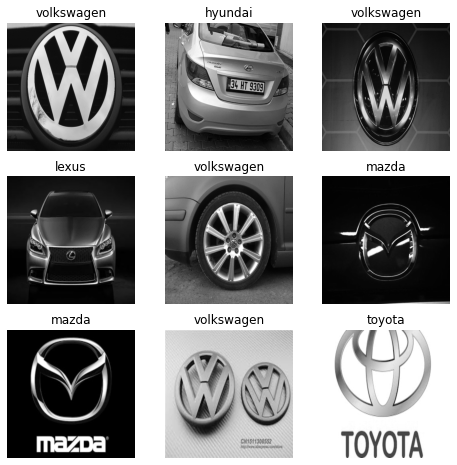

In [8]:
#testing dataset if images are loaded

only_dirs = [ name for name in os.listdir(train_path) if 
                 os.path.isdir(os.path.join(train_path, name)) ]

diz = {}
i=0
for d in only_dirs:
    diz[i] = d
    i+=1

figure = plt.figure(figsize=(8, 8))
cols, rows = 3, 3
for i in range(1, cols * rows + 1):
    sample_idx = torch.randint(len(train_data), size=(1,)).item() 
    img, label = train_data[sample_idx]
    figure.add_subplot(rows, cols, i)
    plt.title(diz[label])
    plt.axis("off")
    plt.imshow(img.squeeze(), cmap='gray')
    # plt.imshow(img.squeeze())
plt.show()

In [9]:
# img, label = train_data[300]

# print(img.shape)

# plt.imshow(img.squeeze(), cmap='gray')

### creating dataloader (who iterate on data, create batches and shuffles it)


Feature batch shape: torch.Size([64, 600, 600, 1])
Labels batch shape: torch.Size([64])


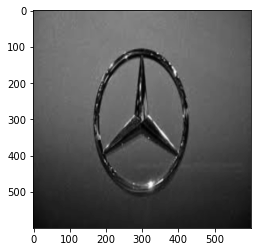

Label: mercedes


In [10]:
train_dl = DataLoader(train_data, batch_size=64, shuffle=True)
test_dl = DataLoader(test_data, batch_size=64, shuffle=True)

#dataloader test (ask a batch or a sample)
images, labels = next(iter(train_dl)) #picking a batch
print(f"Feature batch shape: {images.size()}")
print(f"Labels batch shape: {labels.size()}")
img = images[0].squeeze() #picking the first img and label of the batch
label = labels[0]
plt.imshow(img, cmap='gray')
plt.show()
print(f"Label: {diz[label.item()]}")

In [11]:
# os.rename('./data/car_brand_logos/Train/mercedes/r6.JPG', './data/car_brand_logos/Train/mercedes/r6.jpg')
# image = read_image('./data/car_brand_logos/Train/volkswagen/vosvos-volkswagen-logo-patches-arma-pec-kot-yamasi__1548797389090801.jpg')
# image = image.permute(1,2,0)
# plt.imshow(image, cmap='gray')
# plt.show()

### Defining the neural network

In [12]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

print(device)

cuda:0


In [13]:
class Net(nn.Module):

    def __init__(self):
        super(Net, self).__init__()
        
        #conv1: 1 input image channel (image channel, 1 gray, 3 rgb), 6 output channels (depth [K]), 5x5 square convolution kernel, DEFAULT: stride = 1,1, padding = 0
        self.conv1 = nn.Conv2d(1, 6, 5)
        self.conv2 = nn.Conv2d(6, 10, 5)        
        self.fc_layer1 = nn.Linear(10*147*147, 120)
        
        self.fc_layer2 = nn.Linear(120, 84)
        self.fc_layer3 = nn.Linear(84, i) # i is the num of classes

    def forward(self, x):
        # Max pooling over a (2, 2) window
        x = F.max_pool2d(F.relu(self.conv1(x)), (2, 2))
        # If the size is a square, you can specify with a single number
        x = F.max_pool2d(F.relu(self.conv2(x)), 2)
        x = torch.flatten(x, 1) # flatten all dimensions except the batch dimension
        x = F.relu(self.fc_layer1(x))
        x = F.relu(self.fc_layer2(x))
        x = self.fc_layer3(x)
        return x

In [14]:
net = Net()
# net.to(device)

In [15]:
#test
params = list(net.parameters())
print(len(params))
print(params[0].size())  # conv1's .weight

10
torch.Size([6, 1, 5, 5])


In [16]:
# loss function
criterion = nn.CrossEntropyLoss()
# use gradient descent
#? what's momentum and lr? are they important?
optimizer = optim.SGD(net.parameters(), lr=0.001, momentum=0.9)

### Training the network

In [17]:
for epoch in range(2):  # loop over the dataset multiple times

    running_loss = 0.0
    for i, data in enumerate(train_dl, 0):
        # get the inputs; data is a list of [inputs, labels]
        inputs, labels = data
        # inputs, labels = data[0].to(device), data[1].to(device)
        inputs = inputs.permute(0, 3, 1, 2) # to get a shape of [64, 1, 600, 600]
        
        # inputs = inputs.view(64, -1) #1° param specifico io, altri calcola lui (-1)
        
        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        outputs = net(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        # print statistics
        running_loss += loss.item()
        # print('Num of batches processed: {}'.format(i))
        # if i % 2000 == 1999:    # print every 2000 mini-batches
        print(f'[{epoch + 1}, {i + 1:5d}] loss: {running_loss:.3f}')
        running_loss = 0.0

print('Finished Training')

[1,     1] loss: 2.293
[1,     2] loss: 4.397
[1,     3] loss: 2.217
[1,     4] loss: 2.559
[1,     5] loss: 2.271
[1,     6] loss: 2.215
[1,     7] loss: 2.225
[1,     8] loss: 2.207
[1,     9] loss: 2.209
[1,    10] loss: 2.207
[1,    11] loss: 2.210
[1,    12] loss: 2.198
[1,    13] loss: 2.201
[1,    14] loss: 2.199
[1,    15] loss: 2.200
[1,    16] loss: 2.185
[1,    17] loss: 2.198
[1,    18] loss: 2.184
[1,    19] loss: 2.188
[1,    20] loss: 2.220
[2,     1] loss: 2.160
[2,     2] loss: 2.158
[2,     3] loss: 2.266
[2,     4] loss: 2.204
[2,     5] loss: 2.171
[2,     6] loss: 2.155
[2,     7] loss: 2.162
[2,     8] loss: 2.156
[2,     9] loss: 2.166
[2,    10] loss: 2.147
[2,    11] loss: 2.157
[2,    12] loss: 2.160
[2,    13] loss: 2.158
[2,    14] loss: 2.142
[2,    15] loss: 2.147
[2,    16] loss: 2.145
[2,    17] loss: 2.095
[2,    18] loss: 2.134
[2,    19] loss: 2.114
[2,    20] loss: 2.156
Finished Training


In [18]:
#saving the trained model
PATH = './trained/auto_brand.pth'
torch.save(net.state_dict(), PATH)

### Testing the network on test set

In [19]:
# loaded = Net()
# loaded.load_state_dict(torch.load("./trained/auto_brand.pth"))

tensor([7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 6, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7,
        7, 7, 7, 7, 6, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 6, 7, 7, 7, 7, 7, 7, 7,
        7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7])


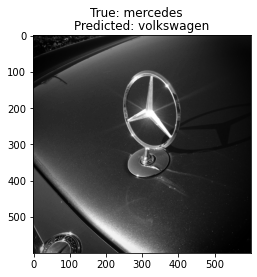

tensor([7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 6, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7,
        7, 7, 7, 7, 6, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 6, 7, 7, 7, 7, 7, 7, 7,
        7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7])


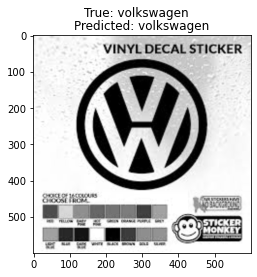

tensor([7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 6, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7,
        7, 7, 7, 7, 6, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 6, 7, 7, 7, 7, 7, 7, 7,
        7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7])


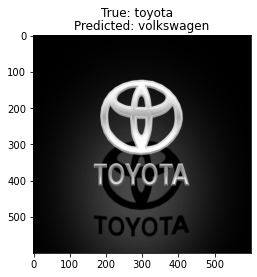

tensor([7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 6, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7,
        7, 7, 7, 7, 6, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 6, 7, 7, 7, 7, 7, 7, 7,
        7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7])


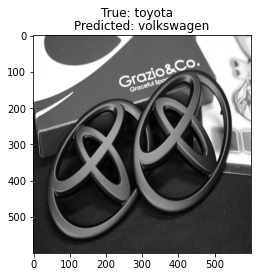

In [20]:
images, labels = next(iter(test_dl)) #picking a batch

for i in range(4):
    rnd_i = torch.randint(len(images), size=(1,)).item() 
    img = images[rnd_i].squeeze()
    label = labels[rnd_i]
    plt.imshow(img, cmap='gray')
    plt.suptitle('True: {}'.format(diz[label.item()]))
    
    #predicting the class of the image
    imgs = images.permute(0, 3, 1, 2)
    preds = net(imgs)
    _, best_pred = torch.max(preds.data, 1)
    plt.title('Predicted: {}'.format(diz[best_pred[rnd_i].item()]))
    print(best_pred)
    plt.show()

In [21]:
# prepare to count predictions for each class
correct_pred = {classname: 0 for classname in diz}
total_pred = {classname: 0 for classname in diz}

y_true = []
y_pred = []

# again no gradients needed
with torch.no_grad():
    for data in test_dl:
        images, labels = data
        images = images.permute(0, 3, 1, 2)
        outputs = net(images)
        _, predictions = torch.max(outputs, 1)
        # collect the correct predictions for each class
        for label, prediction in zip(labels, predictions):
            if label == prediction:
                correct_pred[label.item()] += 1
            total_pred[label.item()] += 1
            y_true.append(label)
            y_pred.append(prediction)

# print accuracy for each class
for classname, correct_count in correct_pred.items():
    accuracy = 100 * float(correct_count) / total_pred[classname]
    print(f'Accuracy for class: {diz[classname]} is {accuracy:.1f} %')

Accuracy for class: hyundai is 0.0 %
Accuracy for class: lexus is 0.0 %
Accuracy for class: mazda is 0.0 %
Accuracy for class: mercedes is 0.0 %
Accuracy for class: opel is 0.0 %
Accuracy for class: skoda is 0.0 %
Accuracy for class: toyota is 0.0 %
Accuracy for class: volkswagen is 98.0 %


In [22]:
#stampa report classificazioni
print(classification_report(y_true, y_pred, target_names=diz.values()))

              precision    recall  f1-score   support

     hyundai       0.00      0.00      0.00        47
       lexus       0.00      0.00      0.00        47
       mazda       0.00      0.00      0.00        47
    mercedes       0.00      0.00      0.00        48
        opel       0.00      0.00      0.00        38
       skoda       0.00      0.00      0.00        46
      toyota       0.00      0.00      0.00        50
  volkswagen       0.14      0.98      0.24        50

    accuracy                           0.13       373
   macro avg       0.02      0.12      0.03       373
weighted avg       0.02      0.13      0.03       373



C:\Users\eliad\miniconda3\envs\tesi\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\eliad\miniconda3\envs\tesi\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\eliad\miniconda3\envs\tesi\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


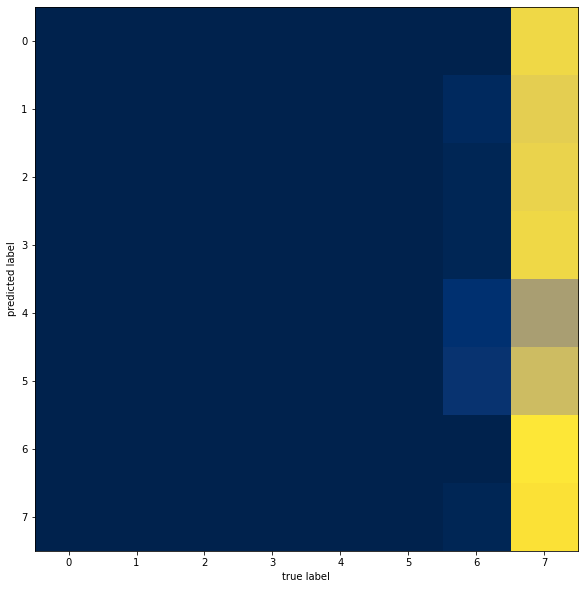

[[ 0  0  0  0  0  0  0 47]
 [ 0  0  0  0  0  0  2 45]
 [ 0  0  0  0  0  0  1 46]
 [ 0  0  0  0  0  0  1 47]
 [ 0  0  0  0  0  0  4 34]
 [ 0  0  0  0  0  0  5 41]
 [ 0  0  0  0  0  0  0 50]
 [ 0  0  0  0  0  0  1 49]]


In [23]:
mat = confusion_matrix(y_true, y_pred)

plt.figure(figsize=(20, 10))
plt.imshow(mat, cmap='cividis')
plt.xlabel('true label')
plt.ylabel('predicted label');
plt.show()

print(mat)